In [51]:
# read csv with pandas
import pandas as pd

data_path = '../data_input/train.csv'
df = pd.read_csv(data_path, usecols=['id', 'text', 'label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157789 entries, 0 to 157788
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      157789 non-null  object
 1   text    157789 non-null  object
 2   label   157789 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [52]:
vocab = set(df['text'].str.cat(sep=' ').split())
len(vocab)

5000

In [53]:
vocab = sorted(list(vocab))

In [54]:
stoi = {s:i+1 for i,s in enumerate(vocab)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [55]:
len(stoi)

5001

In [56]:
import torch

In [57]:
# make X from df['text'] with vtoi
X = df['text'].apply(lambda x: [stoi[v] for v in x.split()])

In [58]:
X[0]

[2516,
 2927,
 1155,
 2516,
 880,
 3663,
 1025,
 3113,
 1652,
 3663,
 3652,
 2927,
 2943,
 2186]

In [59]:
X = X.apply(lambda x: [0]*(30-len(x)) + list(x) if len(x) < 30  else x[:30])

In [60]:
# get pandas item from X
X = torch.tensor(X)

In [61]:
X[0]

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 2516, 2927, 1155, 2516,  880, 3663, 1025, 3113,
        1652, 3663, 3652, 2927, 2943, 2186])

In [62]:
# one hot encode X row element with vocab size
torch.nn.functional.one_hot(X[0], num_classes=len(stoi)).float()

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [63]:
Y = torch.tensor(df['label'])

In [64]:
# split X and Y into train and val, stratify by Y
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [65]:
X_train.shape, X_val.shape

(torch.Size([126231, 30]), torch.Size([31558, 30]))

In [66]:
emb_dim = 5

In [67]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((len(stoi), emb_dim), generator=g)

In [68]:
C.shape

torch.Size([5001, 5])

In [69]:
X_train[range(4)].shape

torch.Size([4, 30])

In [70]:
emb = C[X_train[range(4)]] # (32, 3, 10)
emb.shape

torch.Size([4, 30, 5])

In [71]:
len(vocab)

5000

In [183]:
# forward pass
import torch.nn as nn
import torch.nn.functional as F

class Linear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__(in_features, out_features, bias)
        self.out = None
        
    def forward(self, x):
        self.out = super().forward(x)
        return self.out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        g = torch.Generator().manual_seed(2147483647) # for reproducibility
        C = torch.randn((len(stoi), emb_dim), generator=g)
        # self.C.requires_grad = True
        # set C to be parameters
        self.register_parameter('C', nn.Parameter(C))
        self.fc1 = Linear(30 * emb_dim, 100, bias=False)
        self.bn1 = nn.BatchNorm1d(100)
        self.act1 = nn.Tanh()
        self.fc2 = Linear(100, 20)
        self.act2 = nn.Tanh()
        self.fc3 = Linear(20, 5)
        
    def forward(self, x):
        emb = self.C[x]
        self.fc1.out = self.fc1(emb.view(-1, 30 * emb_dim))
        self.bn1.out = self.bn1(self.fc1.out)
        self.act1.out = self.act1(self.bn1.out)
        self.fc2.out = self.fc2(self.act1.out)
        self.act2.out = self.act2(self.fc2.out)
        self.fc3.out = self.fc3(self.act2.out)
        return self.fc3.out
    
    def get_layers(self):
        layers = []
        for module in self.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.Tanh):
                layers.append(module)
        return layers
    
    def get_parameters(self):
        parameters = [self.C]
        for module in self.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.BatchNorm1d):
                parameters.append(module.weight)
                if module.bias is not None:
                    parameters.append(module.bias)
        return parameters

In [184]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()

In [212]:
parameters = net.parameters()

# print out count of parameters


42330

In [213]:
sum(p.numel() for p in parameters)

0

In [189]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [190]:
layers = net.get_layers()
layers

[Linear(in_features=150, out_features=100, bias=False),
 BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Tanh(),
 Linear(in_features=100, out_features=20, bias=True),
 Tanh(),
 Linear(in_features=20, out_features=5, bias=True)]

In [221]:
for p in net.parameters():

    print(p.grad)

None
None
None
None
None
None
None
None


In [262]:
lossi = []
ud = []

In [275]:
# same optimization as last time
max_steps = 100000
batch_size = 32


# train
for i in range(max_steps):
    # train with batches and consider the last batch
    batch_size = 32
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    outputs = net(X_train[ix])
    loss = criterion(outputs, Y_train[ix])
    
    # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in net.parameters():
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in net.parameters():
      p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 10000:
      pass #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 100000: 1.0387
   1000/ 100000: 1.1158
   2000/ 100000: 1.1927
   3000/ 100000: 1.2483
   4000/ 100000: 1.2639
   5000/ 100000: 1.3732
   6000/ 100000: 1.0139
   7000/ 100000: 0.9608
   8000/ 100000: 1.0570
   9000/ 100000: 1.1277
  10000/ 100000: 1.1656
  11000/ 100000: 1.0567
  12000/ 100000: 1.0822
  13000/ 100000: 1.2469
  14000/ 100000: 1.0169
  15000/ 100000: 1.0935
  16000/ 100000: 1.0920
  17000/ 100000: 1.2662
  18000/ 100000: 0.9779
  19000/ 100000: 0.9816
  20000/ 100000: 1.1304
  21000/ 100000: 1.3097
  22000/ 100000: 1.1241
  23000/ 100000: 1.1023
  24000/ 100000: 0.9611
  25000/ 100000: 1.0636
  26000/ 100000: 1.1107
  27000/ 100000: 0.9960
  28000/ 100000: 1.0146
  29000/ 100000: 1.1441
  30000/ 100000: 1.0403
  31000/ 100000: 1.1457
  32000/ 100000: 1.2535
  33000/ 100000: 0.7500
  34000/ 100000: 1.1511
  35000/ 100000: 1.1536
  36000/ 100000: 1.2225
  37000/ 100000: 1.0021
  38000/ 100000: 1.0230
  39000/ 100000: 1.1107
  40000/ 100000: 0.9977
  41000/ 100000:

In [276]:
outputs = net(X_val)
loss = F.cross_entropy(outputs, Y_val)
loss

tensor(1.2232, grad_fn=<NllLossBackward0>)

In [277]:
from sklearn.metrics import classification_report

Y_pred = outputs.argmax(dim=1).detach().numpy()
Y_true = Y_val.numpy()

print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.59      0.58      0.59      6353
           1       0.37      0.41      0.39      6462
           2       0.35      0.30      0.32      6337
           3       0.43      0.35      0.38      6244
           4       0.58      0.74      0.65      6162

    accuracy                           0.47     31558
   macro avg       0.47      0.47      0.47     31558
weighted avg       0.46      0.47      0.47     31558



In [278]:
print(net.C[0])


tensor([ 1.6411, -0.0504,  0.6932, -1.2872,  0.5409],
       grad_fn=<SelectBackward0>)


layer 2 (Tanh): mean -0.01, std 0.80, saturated: 30.42%
layer 4 (Tanh): mean -0.10, std 0.87, saturated: 52.19%


Text(0.5, 1.0, 'activation distribution')

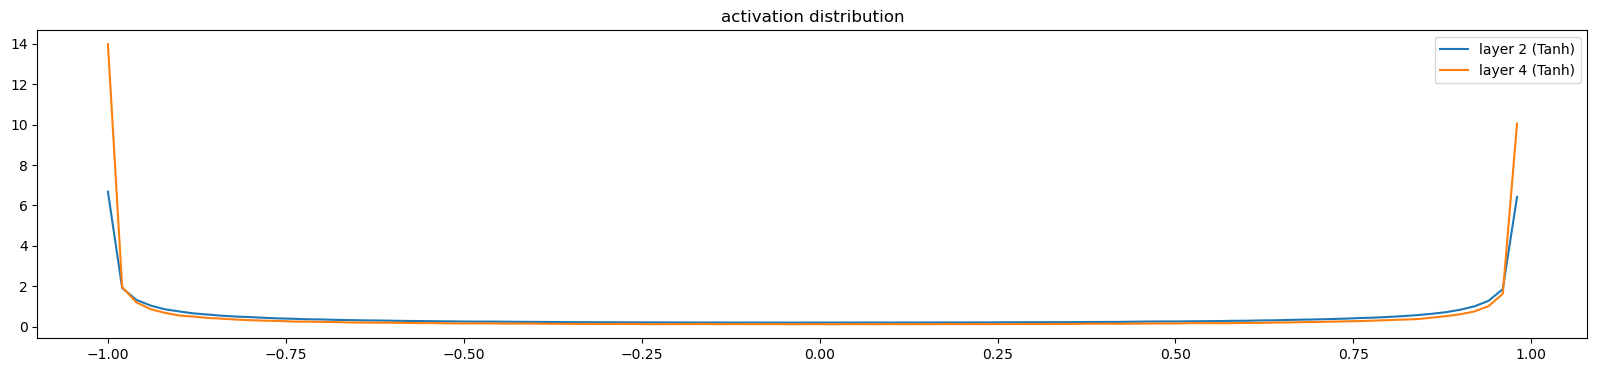

In [279]:
import matplotlib.pyplot as plt

layers = net.get_layers()

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

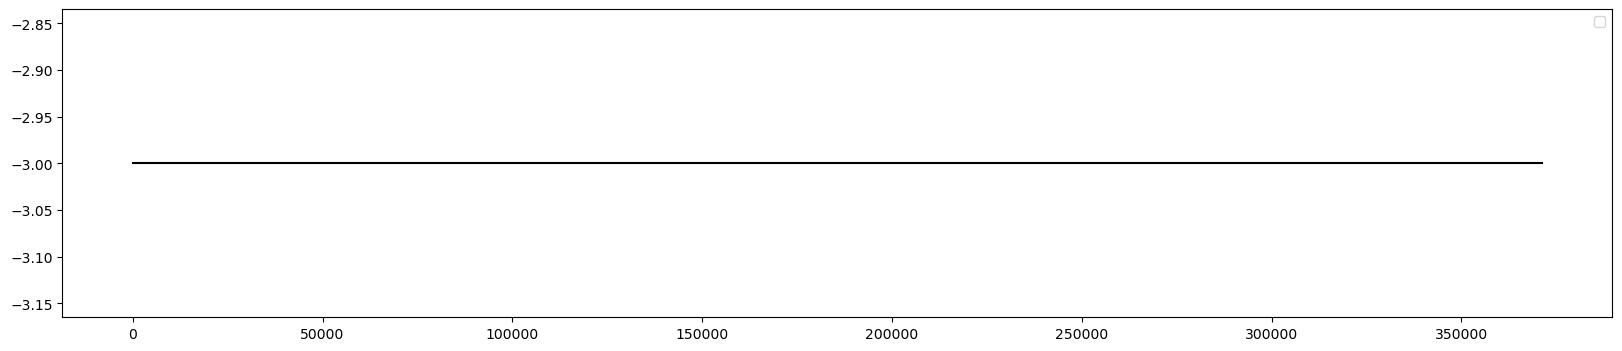

In [280]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);